## Bayesian Polynomial Regression

In [2]:
%pip install pymc pytensor

In [3]:
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import requests
import io
import csv
import pandas as pd
import pymc as pm

In [84]:
target_url = 'https://raw.githubusercontent.com/cfteach/brds/main/datasets/anscombe.csv'

download = requests.get(target_url).content
ans = pd.read_csv(io.StringIO(download.decode('utf-8')))

x = ans[ans.group == 'II']['x'].values
y = ans[ans.group == 'II']['y'].values
x = x - x.mean()

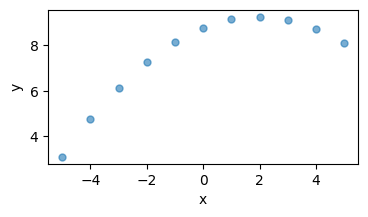

In [85]:
f=plt.figure()
f.set_figwidth(4)
f.set_figheight(2)
plt.xlabel('x')
plt.ylabel('y')
plt.plot(x,y,'C0.',alpha=0.6, markersize=10)

In [86]:
with pm.Model() as model_poly:
  alpha = pm.Normal('alpha',mu=y.mean(),sigma=1)
  beta1 = pm.Normal('beta1',mu=0.,sigma=1)
  beta2 = pm.Normal('beta2',mu=0.,sigma=1)
  epsilon = pm.HalfCauchy('epsilon', 5)

  mu = pm.Deterministic('mu',alpha + beta1*x + beta2*x*x)

  y_pred = pm.Normal('y_pred', mu=mu, sigma = epsilon, observed = y)

  idata_poly = pm.sample(2000, tune = 2000, return_inferencedata=True)

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta1'}>,
        <Axes: title={'center': 'beta1'}>],
       [<Axes: title={'center': 'beta2'}>,
        <Axes: title={'center': 'beta2'}>]], dtype=object)

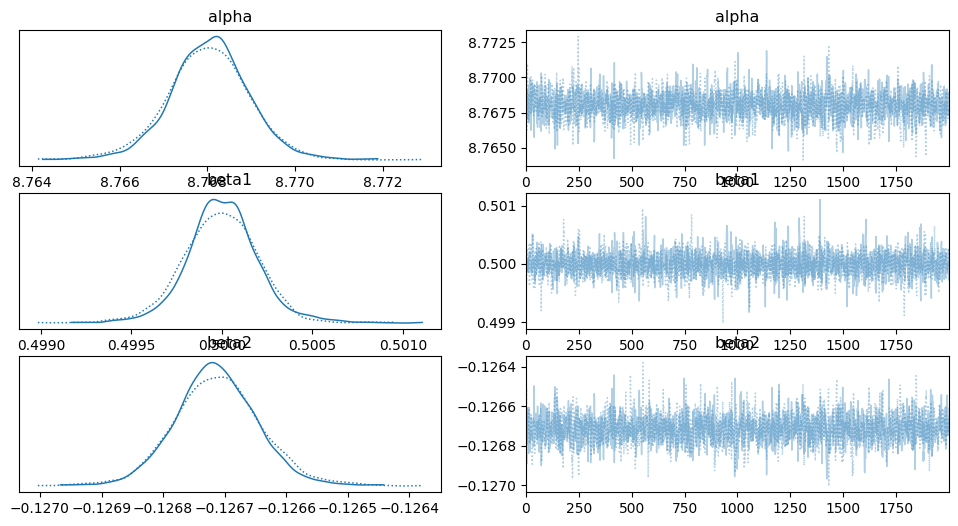

In [87]:
az.plot_trace(idata_poly, var_names = ['alpha','beta1','beta2'])

### Perturbed Dataset

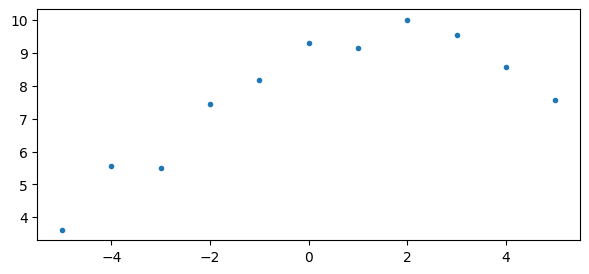

In [92]:
yn = y.copy()

yn += np.random.normal(0,.5, len(yn))

f = plt.figure(figsize=(7,3))
plt.plot(x,yn,'C0.')

In [93]:
with pm.Model() as model_poly2:
  alpha = pm.Normal('alpha',mu=y.mean(),sigma=1)
  beta1 = pm.Normal('beta1',mu=0.,sigma=1)
  beta2 = pm.Normal('beta2',mu=0.,sigma=1)
  epsilon = pm.HalfCauchy('epsilon', 5)

  mu = pm.Deterministic('mu',alpha + beta1*x + beta2*x*x)

  y_pred_per = pm.Normal('y_pred_per', mu=mu, sigma = epsilon, observed = yn)

  idata_poly_per = pm.sample(2000, tune = 2000, return_inferencedata=True)

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta1'}>,
        <Axes: title={'center': 'beta1'}>],
       [<Axes: title={'center': 'beta2'}>,
        <Axes: title={'center': 'beta2'}>],
       [<Axes: title={'center': 'epsilon'}>,
        <Axes: title={'center': 'epsilon'}>],
       [<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>]],
      dtype=object)

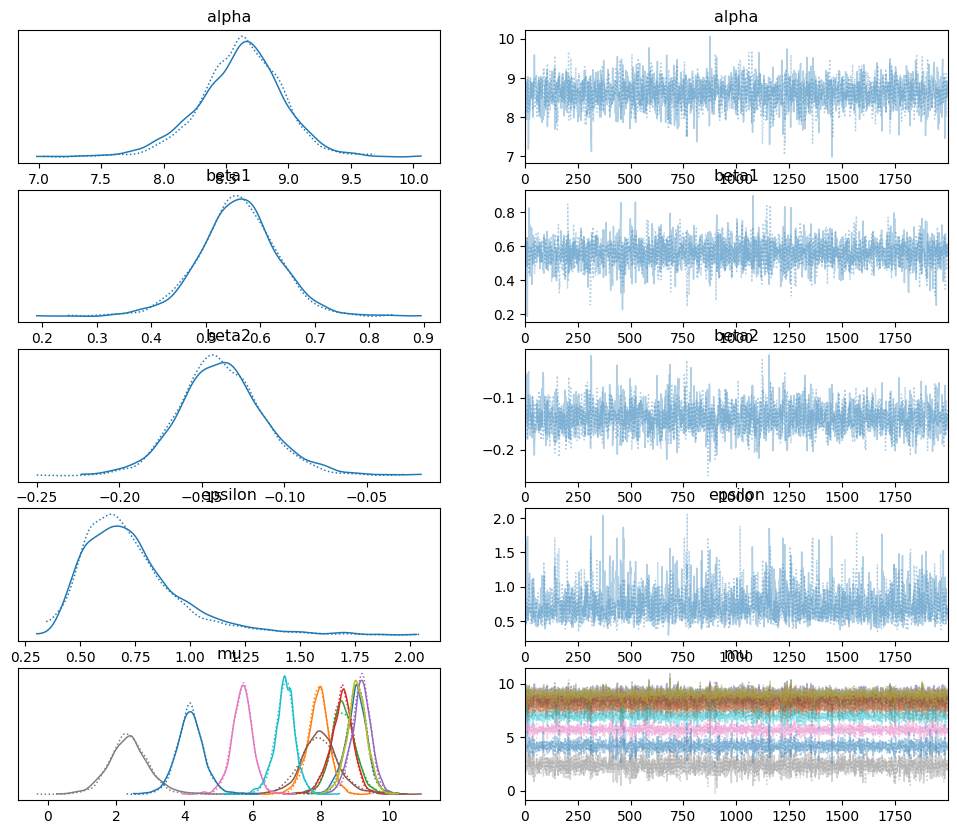

In [10]:
az.plot_trace(idata_poly_per)

In [94]:
res2 = az.summary(idata_poly_per)
print(res2)

          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha    8.926  0.284   8.394    9.458      0.007    0.005    1673.0   
beta1    0.453  0.060   0.340    0.566      0.001    0.001    2647.0   
beta2   -0.129  0.021  -0.168   -0.090      0.001    0.000    1688.0   
epsilon  0.613  0.196   0.315    0.962      0.005    0.004    1716.0   
mu[0]    9.250  0.277   8.716    9.742      0.007    0.005    1709.0   
mu[1]    8.343  0.273   7.856    8.892      0.007    0.005    1785.0   
mu[2]    8.672  0.336   8.004    9.252      0.006    0.005    2892.0   
mu[3]    8.926  0.284   8.394    9.458      0.007    0.005    1673.0   
mu[4]    9.315  0.262   8.835    9.794      0.006    0.004    1958.0   
mu[5]    7.962  0.480   7.057    8.867      0.010    0.007    2518.0   
mu[6]    6.404  0.256   5.923    6.892      0.005    0.003    3055.0   
mu[7]    3.431  0.475   2.546    4.362      0.009    0.007    2557.0   
mu[8]    9.123  0.267   8.633    9.628      0.005    0.004    26

In [95]:
ppc = pm.sample_posterior_predictive(idata_poly_per, model=model_poly2)

<Axes: >

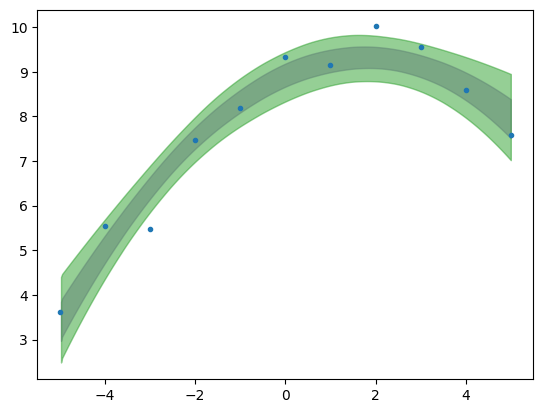

In [96]:
plt.plot(x,yn,'C0.')
az.plot_hdi(x,idata_poly_per.posterior['mu'],color='C4',hdi_prob=.68)
az.plot_hdi(x,idata_poly_per.posterior['mu'],color='C2',hdi_prob=.95)

<Axes: >

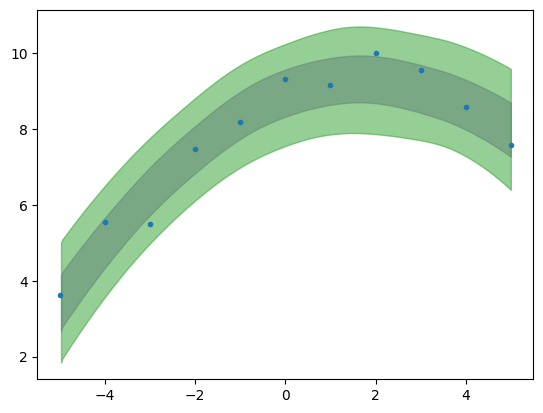

In [97]:
plt.plot(x,yn,'C0.')
az.plot_hdi(x,ppc.posterior_predictive['y_pred_per'],color='C4',hdi_prob=.68)
az.plot_hdi(x,ppc.posterior_predictive['y_pred_per'],color='C2',hdi_prob=.95)

Notice there is a difference between the "uncertainty band" built with the posterior distribution and with the posterior predictive distribution, the latter being larger.

Both the posterior and the posterior predictive distributions incorporate uncertainty due to noise in the data, but they do so in different ways. The posterior reflects this uncertainty in the context of parameter estimation, while the posterior predictive distribution goes a step further, and reflects it in the context of predicting new, unseen outcomes.

Posterior predictive distribution inherently includes both the uncertainty in the parameter estimates and the noise in the data.




In [105]:
import xarray as xr

tmp_y_pred = ppc.posterior_predictive['y_pred_per']
y_pred_merged = xr.concat([tmp_y_pred.sel(chain=i) for i in tmp_y_pred.chain], dim='draw')
# In the context of Bayesian statistics and probabilistic programming (such as when using libraries like PyMC or xarray for
# handling posterior distributions), the term "draw" typically refers to a single sample from the posterior distribution.

In [100]:
np.shape(y_pred_merged)

(4000, 11)

In [101]:
y_pred_means = y_pred_merged.mean(axis=0)
y_pred_std   = y_pred_merged.std(axis=0)

print(np.shape(y_pred_means), np.shape(y_pred_std))

(11,) (11,)


In [102]:
y

array([9.14, 8.14, 8.74, 8.77, 9.26, 8.1 , 6.13, 3.1 , 9.13, 7.26, 4.74])

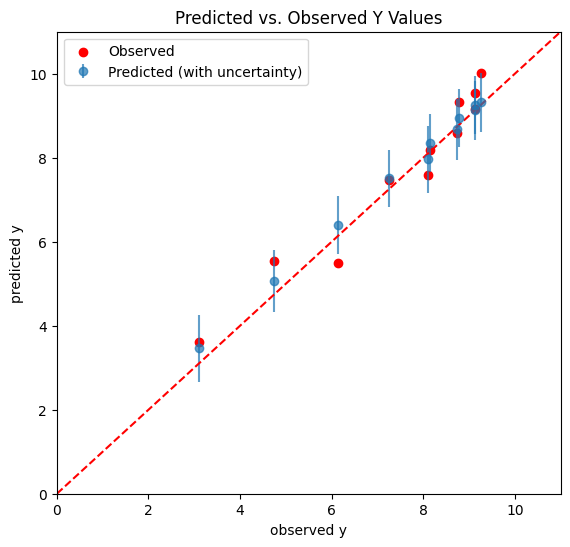

In [104]:
dx = np.linspace(0,11,100)
dy = dx


# Plotting
plt.figure(figsize=(6.5, 6))
plt.errorbar(y, y_pred_means, yerr=y_pred_std, fmt='o', label='Predicted (with uncertainty)', alpha=0.7)
plt.plot(dx,dy,'--',color='r', label = "")
plt.scatter(y, yn, color='r', label='Observed')
plt.xlabel('observed y')
plt.ylabel('predicted y')
plt.title('Predicted vs. Observed Y Values')
plt.xlim((0,11))
plt.ylim((0,11))
plt.legend()
plt.show()